# Project 4 : seattle

Matthieu cazier

Des relevés minutieux ont été effectués par vos agents en 2015 et en 2016. Cependant, ces relevés sont coûteux à obtenir, et à partir de ceux déjà réalisés, vous voulez tenter de prédire les émissions de CO2 et la consommation totale d’énergie de bâtiments pour lesquels elles n’ont pas encore été mesurées.

<ul>
<li>1 -Réaliser une courte analyse exploratoire.
<li>2 -Tester différents modèles de prédiction afin de répondre au mieux à la problématique.
</ul>

Vous cherchez également à évaluer l’intérêt de l’"ENERGY STAR Score" pour la prédiction d’émissions, qui est fastidieux à calculer avec l’approche utilisée actuellement par votre équipe.

L’objectif est de te passer des relevés de consommation annuels (attention à la fuite de données), mais rien ne t'interdit d’en déduire des variables plus simples (nature et proportions des sources d’énergie utilisées). 

Fais bien attention au traitement des différentes variables, à la fois pour trouver de nouvelles informations (peut-on déduire des choses intéressantes d’une simple adresse ?) et optimiser les performances en appliquant des transformations simples aux variables (normalisation, passage au log, etc.).

Mets en place une évaluation rigoureuse des performances de la régression, et optimise les hyperparamètres et le choix d’algorithme de ML à l’aide d’une validation croisée.

Deux notebook seront utilisés
<ul>
<li> Nettoyage des données 
<li> Différents modèles et améliorations    
</ul>

#### Librairies

In [1]:
import pandas as pd
import os 
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from scipy import stats
import missingno as msno
import json
from pandas.io.json import json_normalize


Bad key "text.kerning_factor" on line 4 in
C:\Users\Matthieu\anaconda3\envs\myenv\lib\site-packages\matplotlib\mpl-data\stylelib\_classic_test_patch.mplstyle.
You probably need to get an updated matplotlibrc file from
https://github.com/matplotlib/matplotlib/blob/v3.1.3/matplotlibrc.template
or from the matplotlib source distribution


In [2]:
df_2016 = pd.read_csv('2016-building-energy-benchmarking.csv')
df_2015 = pd.read_csv('2015-building-energy-benchmarking.csv')


#### Faire une copie des dataframes

In [3]:
df_2016 = df_2016.copy()
df_2015 = df_2015.copy()

In [4]:
pd.read_json('data_2015.json', lines=True)

,id,name,attribution,attributionLink,averageRating,createdAt,description,displayType,downloadCount,hideFromCatalog,...,columns,grants,license,metadata,owner,query,rights,tableAuthor,tags,flags
0,h7rm-fz6m,2015 Building Energy Benchmarking,City of Seattle,http://www.seattle.gov/environment,0,1492461362,Seattle’s Building Energy Benchmarking and Rep...,table,2366,False,...,"[{'id': 350402298, 'name': 'OSEBuildingID', 'd...","[{'inherited': False, 'type': 'viewer', 'flags...",{'name': 'Public Domain'},"{'rdfSubject': '0', 'jsonQuery': {'order': [{'...","{'id': '9yyf-ecsx', 'displayName': 'Sullivan, ...","{'orderBys': [{'ascending': True, 'expression'...",[read],"{'id': '9yyf-ecsx', 'displayName': 'Sullivan, ...","[building, eui, benchmarking, energy, electric...","[default, restorable, restorePossibleForType]"


In [5]:
pd.read_json('data_2016.json', lines=True)

,id,name,attribution,attributionLink,averageRating,createdAt,description,displayType,downloadCount,hideFromCatalog,...,columns,grants,license,metadata,owner,query,rights,tableAuthor,tags,flags
0,2bpz-gwpy,2016 Building Energy Benchmarking,City of Seattle,https://www.seattle.gov/energybenchmarking,0,1521070051,Seattle’s Building Energy Benchmarking and Rep...,table,1832,False,...,"[{'id': 349768636, 'name': 'OSEBuildingID', 'd...","[{'inherited': False, 'type': 'viewer', 'flags...",{'name': 'Public Domain'},"{'sidebar': {'width': 482}, 'custom_fields': {...","{'id': '9yyf-ecsx', 'displayName': 'Sullivan, ...",{},[read],"{'id': '9yyf-ecsx', 'displayName': 'Sullivan, ...","[building, eui, energy, steam, electricity, gr...","[default, restorable, restorePossibleForType]"


#### Vu d'ensemble

In [6]:
df_2015.head()

,OSEBuildingID,DataYear,BuildingType,PrimaryPropertyType,PropertyName,TaxParcelIdentificationNumber,Location,CouncilDistrictCode,Neighborhood,YearBuilt,...,GHGEmissionsIntensity(kgCO2e/ft2),DefaultData,Comment,ComplianceStatus,Outlier,2010 Census Tracts,Seattle Police Department Micro Community Policing Plan Areas,City Council Districts,SPD Beats,Zip Codes
0,1,2015,NonResidential,Hotel,MAYFLOWER PARK HOTEL,659000030,"{'latitude': '47.61219025', 'longitude': '-122...",7,DOWNTOWN,1927,...,2.64,No,NaN,Compliant,NaN,NaN,14.0,NaN,31.0,18081
1,2,2015,NonResidential,Hotel,PARAMOUNT HOTEL,659000220,"{'latitude': '47.61310583', 'longitude': '-122...",7,DOWNTOWN,1996,...,2.38,No,NaN,Compliant,NaN,NaN,14.0,NaN,31.0,18081
2,3,2015,NonResidential,Hotel,WESTIN HOTEL,659000475,"{'latitude': '47.61334897', 'longitude': '-122...",7,DOWNTOWN,1969,...,1.92,Yes,NaN,Compliant,NaN,NaN,56.0,NaN,31.0,18081
3,5,2015,NonResidential,Hotel,HOTEL MAX,659000640,"{'latitude': '47.61421585', 'longitude': '-122...",7,DOWNTOWN,1926,...,31.38,No,NaN,Compliant,High Outlier,NaN,56.0,NaN,31.0,18081
4,8,2015,NonResidential,Hotel,WARWICK SEATTLE HOTEL,659000970,"{'latitude': '47.6137544', 'longitude': '-122....",7,DOWNTOWN,1980,...,4.02,No,NaN,Compliant,NaN,NaN,56.0,NaN,31.0,19576


In [7]:
df_2016.head()

,OSEBuildingID,DataYear,BuildingType,PrimaryPropertyType,PropertyName,Address,City,State,ZipCode,TaxParcelIdentificationNumber,...,Electricity(kWh),Electricity(kBtu),NaturalGas(therms),NaturalGas(kBtu),DefaultData,Comments,ComplianceStatus,Outlier,TotalGHGEmissions,GHGEmissionsIntensity
0,1,2016,NonResidential,Hotel,Mayflower park hotel,405 Olive way,Seattle,WA,98101.0,0659000030,...,1.156514e+06,3946027.0,12764.52930,1276453.0,False,NaN,Compliant,NaN,249.98,2.83
1,2,2016,NonResidential,Hotel,Paramount Hotel,724 Pine street,Seattle,WA,98101.0,0659000220,...,9.504252e+05,3242851.0,51450.81641,5145082.0,False,NaN,Compliant,NaN,295.86,2.86
2,3,2016,NonResidential,Hotel,5673-The Westin Seattle,1900 5th Avenue,Seattle,WA,98101.0,0659000475,...,1.451544e+07,49526664.0,14938.00000,1493800.0,False,NaN,Compliant,NaN,2089.28,2.19
3,5,2016,NonResidential,Hotel,HOTEL MAX,620 STEWART ST,Seattle,WA,98101.0,0659000640,...,8.115253e+05,2768924.0,18112.13086,1811213.0,False,NaN,Compliant,NaN,286.43,4.67
4,8,2016,NonResidential,Hotel,WARWICK SEATTLE HOTEL (ID8),401 LENORA ST,Seattle,WA,98121.0,0659000970,...,1.573449e+06,5368607.0,88039.98438,8803998.0,False,NaN,Compliant,NaN,505.01,2.88


In [8]:
df_2016.columns

Index(['OSEBuildingID', 'DataYear', 'BuildingType', 'PrimaryPropertyType',
       'PropertyName', 'Address', 'City', 'State', 'ZipCode',
       'TaxParcelIdentificationNumber', 'CouncilDistrictCode', 'Neighborhood',
       'Latitude', 'Longitude', 'YearBuilt', 'NumberofBuildings',
       'NumberofFloors', 'PropertyGFATotal', 'PropertyGFAParking',
       'PropertyGFABuilding(s)', 'ListOfAllPropertyUseTypes',
       'LargestPropertyUseType', 'LargestPropertyUseTypeGFA',
       'SecondLargestPropertyUseType', 'SecondLargestPropertyUseTypeGFA',
       'ThirdLargestPropertyUseType', 'ThirdLargestPropertyUseTypeGFA',
       'YearsENERGYSTARCertified', 'ENERGYSTARScore', 'SiteEUI(kBtu/sf)',
       'SiteEUIWN(kBtu/sf)', 'SourceEUI(kBtu/sf)', 'SourceEUIWN(kBtu/sf)',
       'SiteEnergyUse(kBtu)', 'SiteEnergyUseWN(kBtu)', 'SteamUse(kBtu)',
       'Electricity(kWh)', 'Electricity(kBtu)', 'NaturalGas(therms)',
       'NaturalGas(kBtu)', 'DefaultData', 'Comments', 'ComplianceStatus',
       'Outlier

In [9]:
df_2015.columns

Index(['OSEBuildingID', 'DataYear', 'BuildingType', 'PrimaryPropertyType',
       'PropertyName', 'TaxParcelIdentificationNumber', 'Location',
       'CouncilDistrictCode', 'Neighborhood', 'YearBuilt', 'NumberofBuildings',
       'NumberofFloors', 'PropertyGFATotal', 'PropertyGFAParking',
       'PropertyGFABuilding(s)', 'ListOfAllPropertyUseTypes',
       'LargestPropertyUseType', 'LargestPropertyUseTypeGFA',
       'SecondLargestPropertyUseType', 'SecondLargestPropertyUseTypeGFA',
       'ThirdLargestPropertyUseType', 'ThirdLargestPropertyUseTypeGFA',
       'YearsENERGYSTARCertified', 'ENERGYSTARScore', 'SiteEUI(kBtu/sf)',
       'SiteEUIWN(kBtu/sf)', 'SourceEUI(kBtu/sf)', 'SourceEUIWN(kBtu/sf)',
       'SiteEnergyUse(kBtu)', 'SiteEnergyUseWN(kBtu)', 'SteamUse(kBtu)',
       'Electricity(kWh)', 'Electricity(kBtu)', 'NaturalGas(therms)',
       'NaturalGas(kBtu)', 'OtherFuelUse(kBtu)',
       'GHGEmissions(MetricTonsCO2e)', 'GHGEmissionsIntensity(kgCO2e/ft2)',
       'DefaultData', '

In [10]:
print(df_2016.shape)
print(df_2015.shape)

(3376, 46)
(3340, 47)


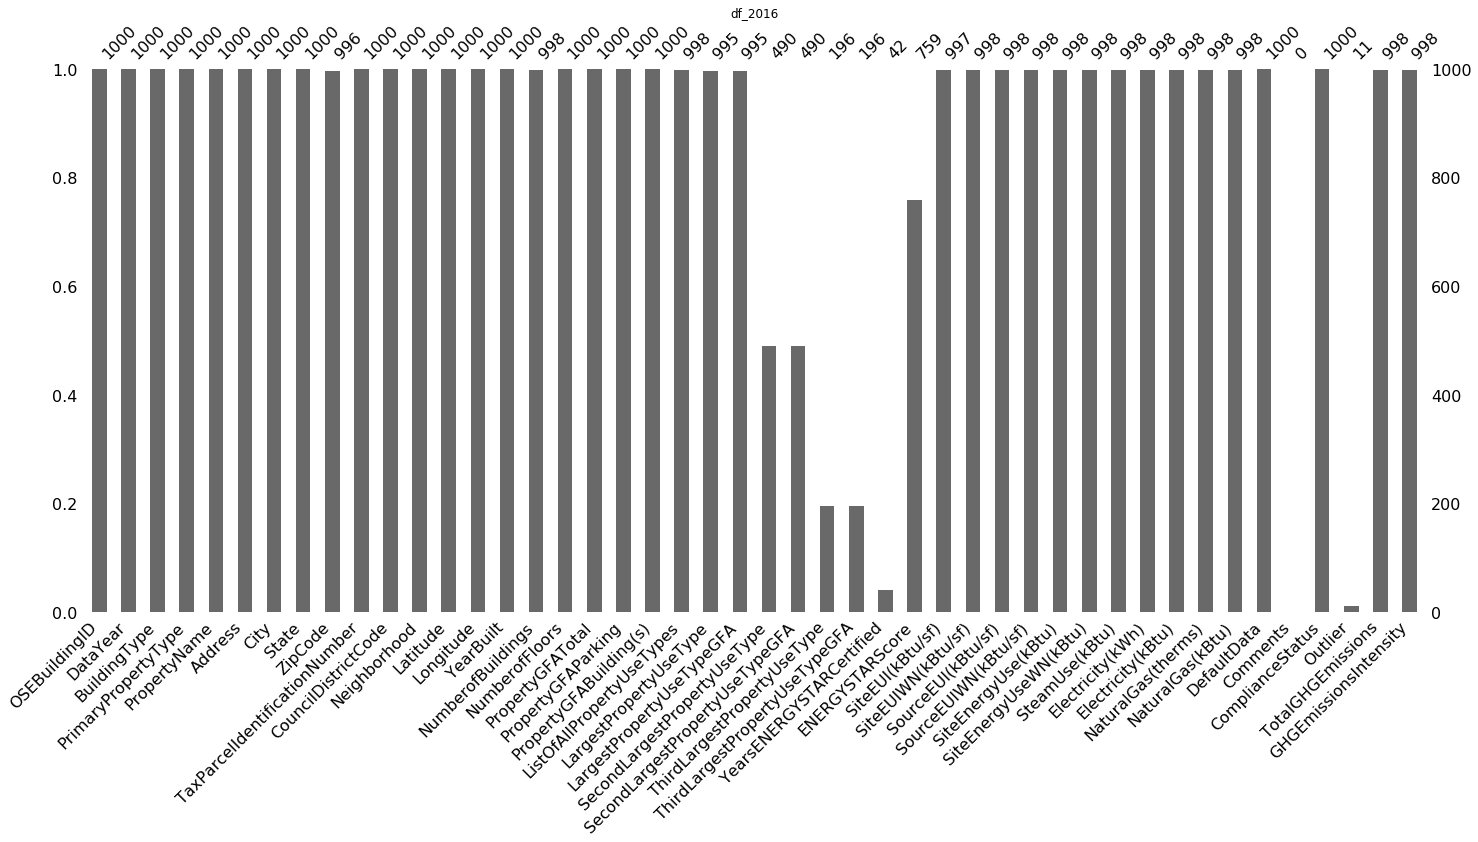

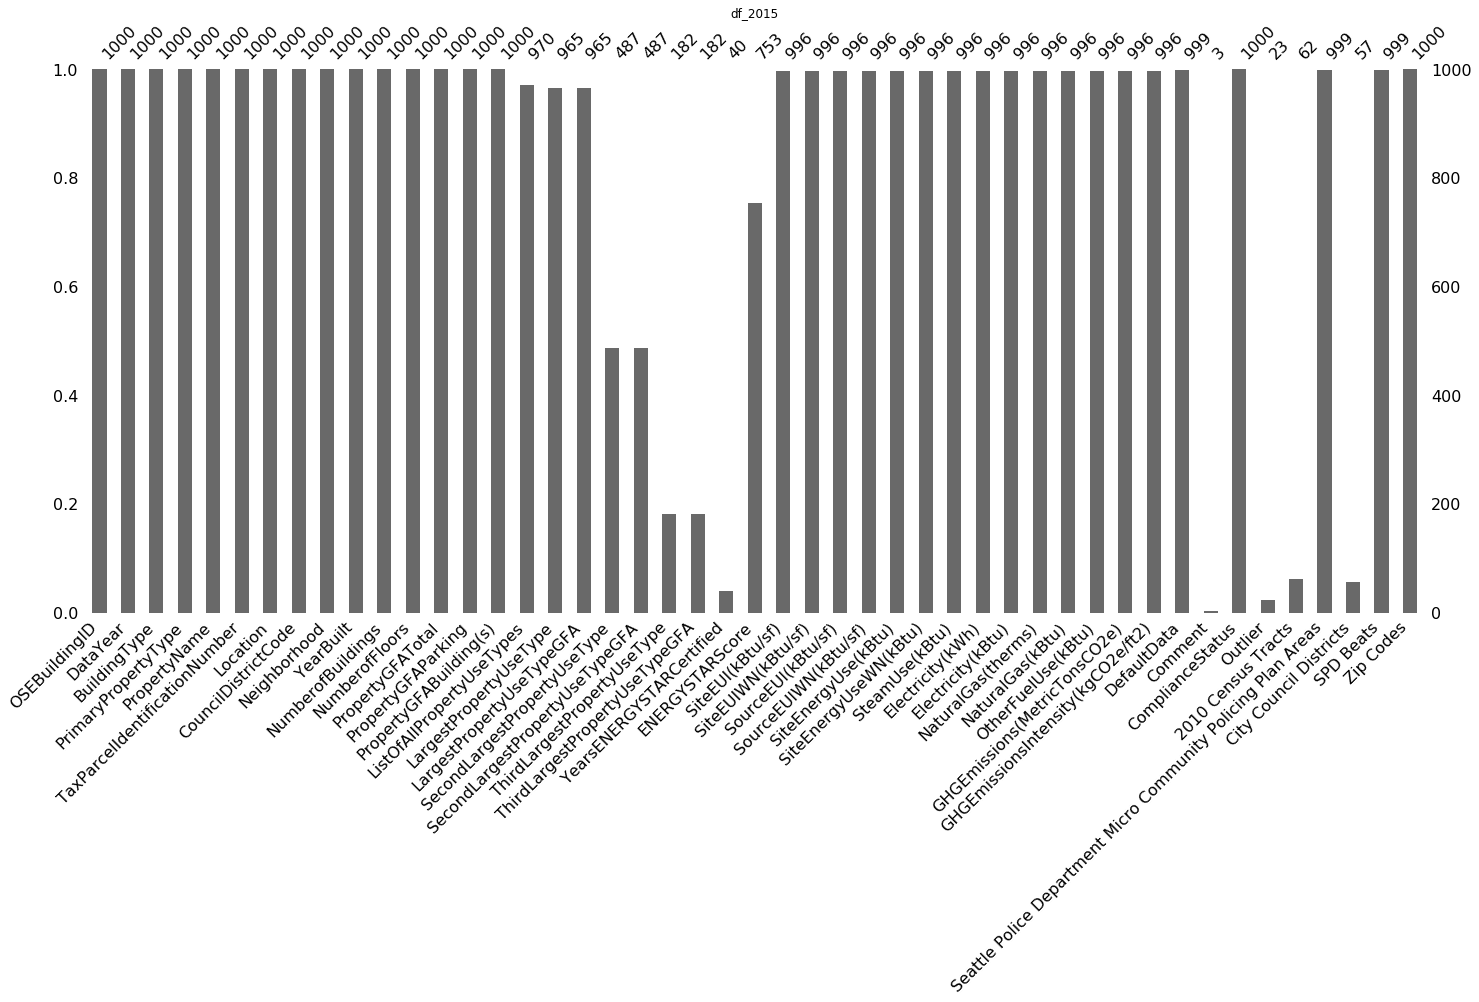

In [11]:
plt.figure()
msno.bar(df_2016.sample(1000))
plt.title('df_2016')
plt.figure()
plt.title('df_2015')
msno.bar(df_2015.sample(1000))

In [12]:
df_2016["Outlier"].value_counts(normalize=False)#.plot(kind='pie')

Low outlier     23
High outlier     9
Name: Outlier, dtype: int64

In [13]:
df_2016.shape

(3376, 46)

In [14]:
df_2015.shape

(3340, 47)

#### Supprimer les outliers

In [15]:
df_2016 = df_2016.loc[df_2016["Outlier"] != "Low outlier"]
df_2016 = df_2016.loc[df_2016["Outlier"] != "High outlier"]
df_2015 = df_2015.loc[df_2015["Outlier"] != "Low outlier"]
df_2015 = df_2015.loc[df_2015["Outlier"] != "High outlier"]

In [16]:
df_2016.shape

(3344, 46)

In [17]:
df_2015.shape

(3340, 47)

In [18]:
df_2016['Outlier']

0       NaN
1       NaN
2       NaN
3       NaN
4       NaN
       ... 
3371    NaN
3372    NaN
3373    NaN
3374    NaN
3375    NaN
Name: Outlier, Length: 3344, dtype: object

In [19]:
df_2015['Outlier']

0                NaN
1                NaN
2                NaN
3       High Outlier
4                NaN
            ...     
3335             NaN
3336             NaN
3337             NaN
3338             NaN
3339             NaN
Name: Outlier, Length: 3340, dtype: object

#### Supprimer les colonnes qui ont 80% de données manquantes

In [20]:
df_2016 = df_2016[df_2016.columns[df_2016.isna().sum()/df_2016.shape[0] < 0.8]]
df_2015 = df_2015[df_2015.columns[df_2015.isna().sum()/df_2015.shape[0] < 0.8]] 

In [22]:
df_2016.shape

(3344, 41)

In [23]:
df_2015.shape

(3340, 40)

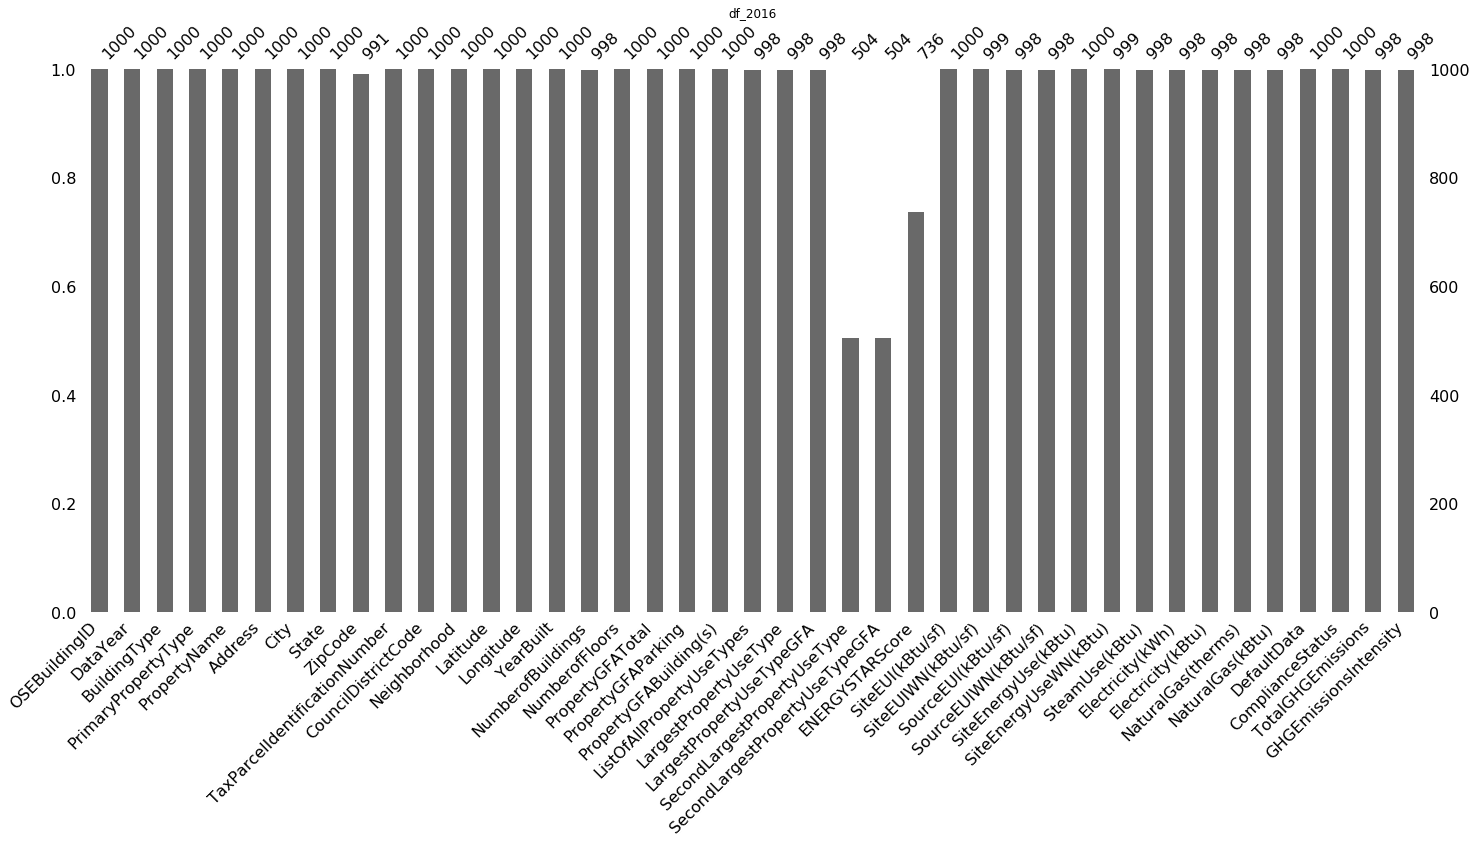

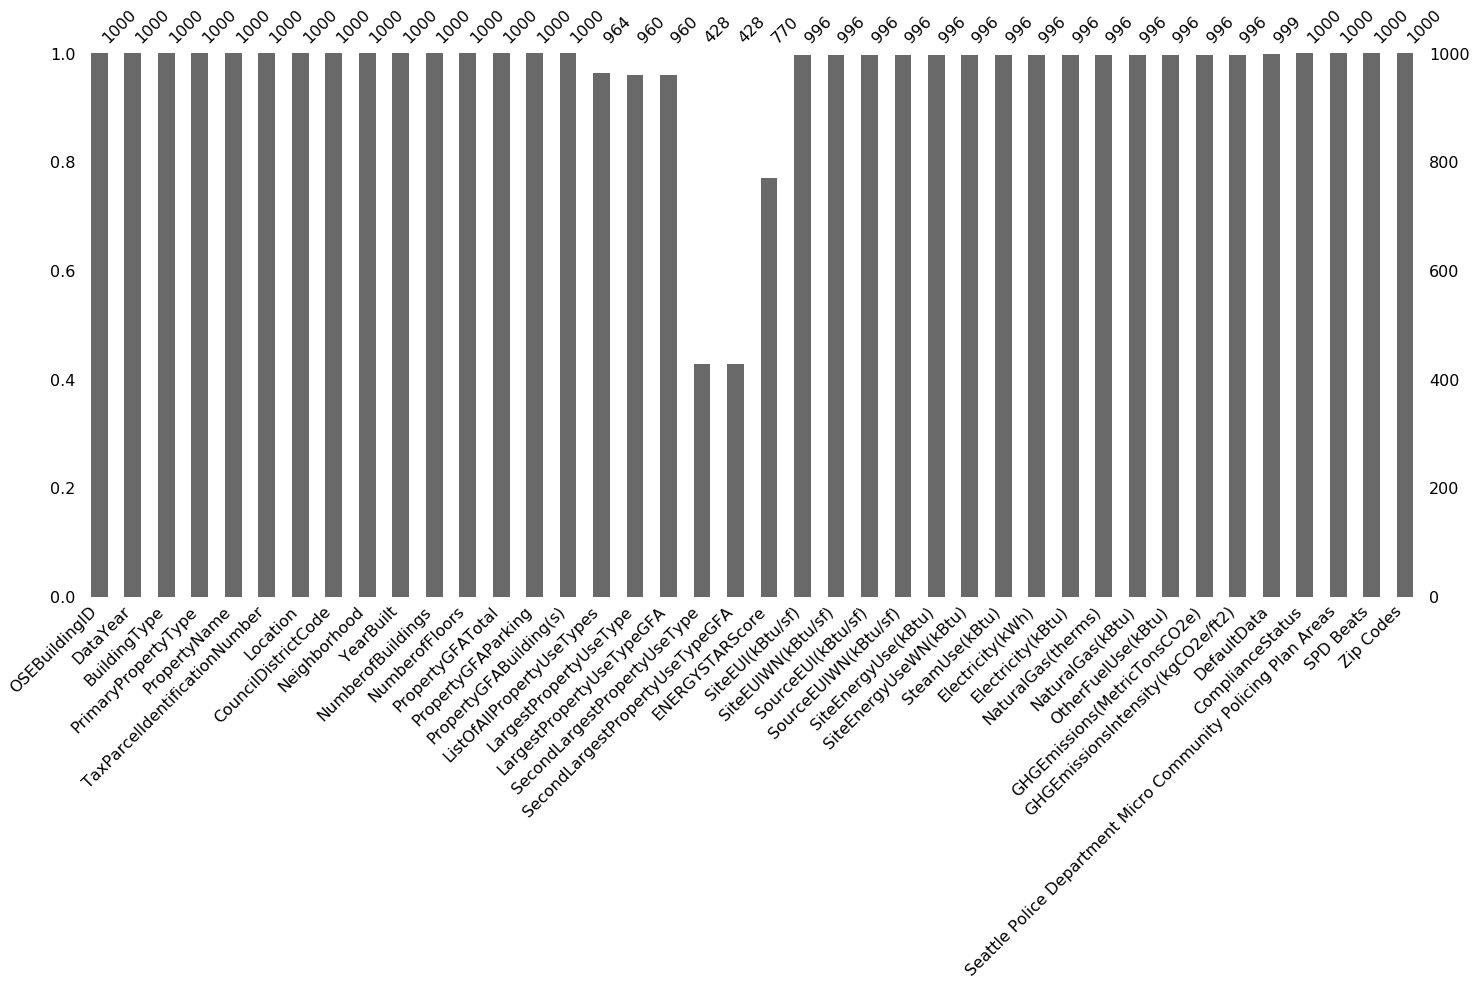

In [21]:
plt.figure()
msno.bar(df_2016.sample(1000))
plt.title('df_2016')
plt.figure('df_2015')
msno.bar(df_2015.sample(1000))

In [22]:
print('Colonnes présentes sur données 2015 et absentes sur 2016 : \n', set(df_2015.columns) - set(df_2016.columns))
print('\nColonnes présentes sur données 2016 et absentes sur 2015 : \n', set(df_2016.columns) - set(df_2015.columns))

Colonnes présentes sur données 2015 et absentes sur 2016 : 
 {'SPD Beats', 'Location', 'OtherFuelUse(kBtu)', 'Zip Codes', 'GHGEmissions(MetricTonsCO2e)', 'GHGEmissionsIntensity(kgCO2e/ft2)', 'Seattle Police Department Micro Community Policing Plan Areas'}

Colonnes présentes sur données 2016 et absentes sur 2015 : 
 {'State', 'Longitude', 'Latitude', 'ZipCode', 'Address', 'City', 'TotalGHGEmissions', 'GHGEmissionsIntensity'}


#### Récupérer les données dans la colonne location

In [23]:
import ast
import json  
from pandas.io.json import json_normalize

def transform_columns (dataframe):

        
    #ajout des informations des colonnes manquantes
    location = pd.DataFrame()
    for line, building_id in zip(df_2015['Location'], df_2015['OSEBuildingID']):
        line = ast.literal_eval(line)
        line = json_normalize(line)
        
        latitude = line['latitude'][0]
        longitude = line['longitude'][0]

        line = pd.DataFrame(ast.literal_eval(line['human_address'][0]), index=[0])
        location = pd.concat([location,
                             pd.DataFrame({
                       'Building_id' : building_id,
                       'Address' : line['address'][0],
                       'City' : line['city'][0],
                       'State' : line['state'][0],
                       'ZipCode' : line['zip'][0],
                       'Latitude' : latitude,
                       'Longitude': longitude }, index=[0])],
                             axis=0)
    return pd.merge(dataframe, location, left_on = 'OSEBuildingID', 
                    right_on = 'Building_id').drop(['Building_id','Location'],axis=1)

In [24]:
df_2015 = transform_columns(df_2015)

C:\Users\Matthieu\anaconda3\envs\myenv\lib\site-packages\ipykernel_launcher.py:16: FutureWarning: pandas.io.json.json_normalize is deprecated, use pandas.json_normalize instead
  app.launch_new_instance()


In [25]:
print('colonnes présentes sur données 2015 et absentes sur 2016 : \n', set(df_2015.columns) - set(df_2016.columns))
print('\ncolonnes présentes sur données 2016 et absentes sur 2015 : \n', set(df_2016.columns) - set(df_2015.columns))

colonnes présentes sur données 2015 et absentes sur 2016 : 
 {'SPD Beats', 'OtherFuelUse(kBtu)', 'Zip Codes', 'GHGEmissions(MetricTonsCO2e)', 'GHGEmissionsIntensity(kgCO2e/ft2)', 'Seattle Police Department Micro Community Policing Plan Areas'}

colonnes présentes sur données 2016 et absentes sur 2015 : 
 {'GHGEmissionsIntensity', 'TotalGHGEmissions'}


#### Exploration des deux variables qui restent (totalGHGEmission & GHGEmissionsIntensity)

In [26]:
pd.set_option('display.max_columns', 50)

In [27]:
df_2016['GHGEmissionsIntensity']

0        2.83
1        2.86
2        2.19
3        4.67
4        2.88
        ...  
3371     1.70
3372     2.01
3373    16.99
3374     1.57
3375     2.26
Name: GHGEmissionsIntensity, Length: 3344, dtype: float64

In [28]:
df_2016['TotalGHGEmissions']

0        249.98
1        295.86
2       2089.28
3        286.43
4        505.01
         ...   
3371      20.94
3372      32.17
3373     223.54
3374      22.11
3375      41.27
Name: TotalGHGEmissions, Length: 3344, dtype: float64

In [29]:
df_2015['GHGEmissionsIntensity(kgCO2e/ft2)']

0        2.64
1        2.38
2        1.92
3       31.38
4        4.02
        ...  
3335     0.07
3336     0.61
3337     1.89
3338     0.04
3339     0.05
Name: GHGEmissionsIntensity(kgCO2e/ft2), Length: 3340, dtype: float64

In [30]:
df_2015['GHGEmissions(MetricTonsCO2e)']

0        249.43
1        263.51
2       2061.48
3       1936.34
4        507.70
         ...   
3335       7.97
3336      30.69
3337     627.97
3338       5.42
3339       6.74
Name: GHGEmissions(MetricTonsCO2e), Length: 3340, dtype: float64

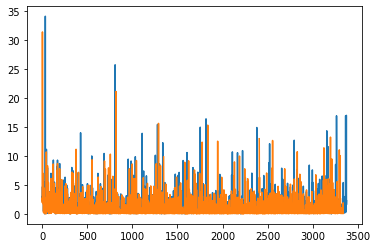

In [31]:
plt.figure
plt.plot(df_2016['GHGEmissionsIntensity'])
plt.plot(df_2015['GHGEmissionsIntensity(kgCO2e/ft2)'])

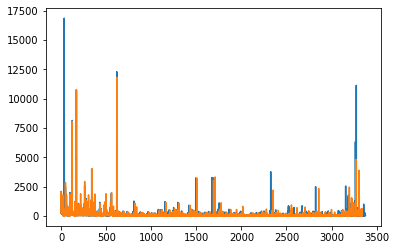

In [32]:
plt.figure
plt.plot(df_2016['TotalGHGEmissions'])
plt.plot(df_2015['GHGEmissions(MetricTonsCO2e)'])

#### rassembler les deux variables au nom correspondant

In [33]:
df_2015['TotalGHGEmissions'] = df_2015['GHGEmissions(MetricTonsCO2e)']
df_2015['GHGEmissionsIntensity'] = df_2015['GHGEmissionsIntensity(kgCO2e/ft2)']
df_2015.drop(['GHGEmissions(MetricTonsCO2e)', 'GHGEmissionsIntensity(kgCO2e/ft2)'], axis=1, inplace=True)

In [34]:
df_2015.shape

(3340, 45)

In [35]:
df_2016.shape

(3344, 41)

In [36]:
print('colonnes présentes sur données 2015 et absentes sur 2016 : \n', set(df_2015.columns) - set(df_2016.columns))
print('\ncolonnes présentes sur données 2016 et absentes sur 2015 : \n', set(df_2016.columns) - set(df_2015.columns))

colonnes présentes sur données 2015 et absentes sur 2016 : 
 {'OtherFuelUse(kBtu)', 'Zip Codes', 'SPD Beats', 'Seattle Police Department Micro Community Policing Plan Areas'}

colonnes présentes sur données 2016 et absentes sur 2015 : 
 set()


In [37]:
df_2015 = df_2015.drop(['OtherFuelUse(kBtu)','Zip Codes','SPD Beats','Seattle Police Department Micro Community Policing Plan Areas'],axis=1)

In [38]:
print('colonnes présentes sur données 2015 et absentes sur 2016 : \n', set(df_2015.columns) - set(df_2016.columns))
print('\ncolonnes présentes sur données 2016 et absentes sur 2015 : \n', set(df_2016.columns) - set(df_2015.columns))

colonnes présentes sur données 2015 et absentes sur 2016 : 
 set()

colonnes présentes sur données 2016 et absentes sur 2015 : 
 set()


###### Vérifier que les deux DF ont les mêmes dtypes

In [39]:
pd.DataFrame([df_2015.dtypes, df_2016.dtypes])

,OSEBuildingID,DataYear,BuildingType,PrimaryPropertyType,PropertyName,TaxParcelIdentificationNumber,CouncilDistrictCode,Neighborhood,YearBuilt,NumberofBuildings,NumberofFloors,PropertyGFATotal,PropertyGFAParking,PropertyGFABuilding(s),ListOfAllPropertyUseTypes,LargestPropertyUseType,LargestPropertyUseTypeGFA,SecondLargestPropertyUseType,SecondLargestPropertyUseTypeGFA,ENERGYSTARScore,SiteEUI(kBtu/sf),SiteEUIWN(kBtu/sf),SourceEUI(kBtu/sf),SourceEUIWN(kBtu/sf),SiteEnergyUse(kBtu),SiteEnergyUseWN(kBtu),SteamUse(kBtu),Electricity(kWh),Electricity(kBtu),NaturalGas(therms),NaturalGas(kBtu),DefaultData,ComplianceStatus,Address,City,State,ZipCode,Latitude,Longitude,TotalGHGEmissions,GHGEmissionsIntensity
0,int64,int64,object,object,object,object,int64,object,int64,int64,float64,int64,int64,int64,object,object,float64,object,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,object,object,object,object,object,object,object,object,float64,float64
1,int64,int64,object,object,object,object,int64,object,int64,float64,int64,int64,int64,int64,object,object,float64,object,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,bool,object,object,object,object,float64,float64,float64,float64,float64


#### Regarder les colonnes avec des données différentes 

NumberofBuildings(int/float) / NumberofFloors(int/float) / DefaultData (objet/bool) / ZipCode (objet/float) /
Latitude (objet/float) / Longitude (objet/float)

In [40]:
df_2015['NumberofBuildings']

0       1
1       1
2       1
3       1
4       1
       ..
3335    1
3336    1
3337    1
3338    1
3339    1
Name: NumberofBuildings, Length: 3340, dtype: int64

In [41]:
df_2016['NumberofBuildings']

0       1.0
1       1.0
2       1.0
3       1.0
4       1.0
       ... 
3371    1.0
3372    1.0
3373    1.0
3374    1.0
3375    1.0
Name: NumberofBuildings, Length: 3344, dtype: float64

###### Passer 2015 en float 

In [42]:
df_2015['NumberofFloors']

0       12.0
1       11.0
2       41.0
3       10.0
4       18.0
        ... 
3335     4.0
3336     7.0
3337    40.0
3338     3.0
3339     4.0
Name: NumberofFloors, Length: 3340, dtype: float64

In [43]:
df_2016['NumberofFloors']

0       12
1       11
2       41
3       10
4       18
        ..
3371     1
3372     1
3373     1
3374     1
3375     1
Name: NumberofFloors, Length: 3344, dtype: int64

###### Passer 2015 en float

In [44]:
df_2015['DefaultData']

0        No
1        No
2       Yes
3        No
4        No
       ... 
3335     No
3336     No
3337     No
3338     No
3339     No
Name: DefaultData, Length: 3340, dtype: object

In [45]:
df_2016['DefaultData']

0       False
1       False
2       False
3       False
4       False
        ...  
3371     True
3372    False
3373    False
3374    False
3375    False
Name: DefaultData, Length: 3344, dtype: bool

###### Passer 2015 en bool

###### ZipCode,Latitude,Longitude passés en float

In [46]:
df_2015[['Latitude','Longitude', 'ZipCode','NumberofBuildings']] = df_2015[['Latitude','Longitude', 'ZipCode','NumberofBuildings']].astype('float64')
df_2016[['NumberofFloors']] = df_2016[['NumberofFloors']].astype('float64')
#les 5 variables en float

In [47]:
df_2015['DefaultData'] = df_2015['DefaultData'].map({'Yes' : True , 'No' : False})

In [48]:
pd.DataFrame([df_2015.dtypes, df_2016.dtypes])

,OSEBuildingID,DataYear,BuildingType,PrimaryPropertyType,PropertyName,TaxParcelIdentificationNumber,CouncilDistrictCode,Neighborhood,YearBuilt,NumberofBuildings,NumberofFloors,PropertyGFATotal,PropertyGFAParking,PropertyGFABuilding(s),ListOfAllPropertyUseTypes,LargestPropertyUseType,LargestPropertyUseTypeGFA,SecondLargestPropertyUseType,SecondLargestPropertyUseTypeGFA,ENERGYSTARScore,SiteEUI(kBtu/sf),SiteEUIWN(kBtu/sf),SourceEUI(kBtu/sf),SourceEUIWN(kBtu/sf),SiteEnergyUse(kBtu),SiteEnergyUseWN(kBtu),SteamUse(kBtu),Electricity(kWh),Electricity(kBtu),NaturalGas(therms),NaturalGas(kBtu),DefaultData,ComplianceStatus,Address,City,State,ZipCode,Latitude,Longitude,TotalGHGEmissions,GHGEmissionsIntensity
0,int64,int64,object,object,object,object,int64,object,int64,float64,float64,int64,int64,int64,object,object,float64,object,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,object,object,object,object,object,float64,float64,float64,float64,float64
1,int64,int64,object,object,object,object,int64,object,int64,float64,float64,int64,int64,int64,object,object,float64,object,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,bool,object,object,object,object,float64,float64,float64,float64,float64


#### Il n'y a plus de colonnes différentes on va pouvoir assembler les deux DF

In [49]:
df = pd.concat([df_2015, df_2016], axis=0, sort=False)

In [50]:
pd.set_option('display.max_columns',41)
pd.set_option('display.max_rows',41)

In [51]:
df['OSEBuildingID'].head(10)

0     1
1     2
2     3
3     5
4     8
5     9
6    10
7    11
8    12
9    13
Name: OSEBuildingID, dtype: int64

In [52]:
df.shape

(6684, 41)

#### Supprimer les duplicates 

In [53]:
df.shape

(6684, 41)

In [54]:
df = df.drop_duplicates(subset=['OSEBuildingID'],keep='last')

In [55]:
df.shape

(3430, 41)

#### Eliminer les batiments residentiels (consigne)

In [56]:
df['BuildingType'].unique()             #supprime multifamily

array(['Multifamily LR (1-4)', 'NonResidential', 'Multifamily HR (10+)',
       'SPS-District K-12', 'Multifamily MR (5-9)', 'Nonresidential COS',
       'Campus', 'Nonresidential WA'], dtype=object)

In [57]:
df = df[(df['BuildingType'] != 'Multifamily MR (5-9)') & (df['BuildingType']!='Multifamily HR (10+)')& (df['BuildingType']!='Multifamily LR (1-4)')]

In [58]:
df['BuildingType'].unique()  

array(['NonResidential', 'SPS-District K-12', 'Nonresidential COS',
       'Campus', 'Nonresidential WA'], dtype=object)

In [59]:
df.shape

(1698, 41)

#### Erreur d'écriture (minimiser le nombre de valeurs dans les colonnes)

In [60]:
for col in df:    
    effectifs = df[col].value_counts()
    modalites = effectifs.index # l'index de effectifs contient les modalités

    tab = pd.DataFrame(modalites, columns = [col]) # création du tableau à partir des modalités
    tab["n"] = effectifs.values
    tab["f"] = tab["n"] / len(df) # len(data) renvoie la taille de l'échantillon
    print(tab)
    print('\n')

      OSEBuildingID  n         f
0             49865  1  0.000589
1             25670  1  0.000589
2             27721  1  0.000589
3             25674  1  0.000589
4             21580  1  0.000589
...             ... ..       ...
1693            543  1  0.000589
1694            545  1  0.000589
1695            547  1  0.000589
1696          23076  1  0.000589
1697              2  1  0.000589

[1698 rows x 3 columns]


   DataYear     n        f
0      2016  1651  0.97232
1      2015    47  0.02768


         BuildingType     n         f
0      NonResidential  1488  0.876325
1   SPS-District K-12    99  0.058304
2  Nonresidential COS    85  0.050059
3              Campus    25  0.014723
4   Nonresidential WA     1  0.000589


            PrimaryPropertyType    n         f
0   Small- and Mid-Sized Office  298  0.175501
1                         Other  257  0.151355
2                     Warehouse  187  0.110130
3                  Large Office  176  0.103651
4                   K-12 Scho

     SteamUse(kBtu)     n         f
0      0.000000e+00  1579  0.929918
1      7.625423e+05     1  0.000589
2      1.639341e+06     1  0.000589
3      8.156761e+05     1  0.000589
4      2.309893e+05     1  0.000589
..              ...   ...       ...
112    3.593940e+06     1  0.000589
113    7.489847e+05     1  0.000589
114    6.090188e+06     1  0.000589
115    5.482947e+05     1  0.000589
116    2.123080e+04     1  0.000589

[117 rows x 3 columns]


      Electricity(kWh)   n         f
0         0.000000e+00  11  0.006478
1         2.390116e+05   2  0.001178
2         1.198617e+06   1  0.000589
3         3.576907e+06   1  0.000589
4         3.733872e+05   1  0.000589
...                ...  ..       ...
1679      1.190574e+07   1  0.000589
1680      1.622399e+06   1  0.000589
1681      1.471839e+06   1  0.000589
1682      8.833767e+05   1  0.000589
1683      1.498000e+05   1  0.000589

[1684 rows x 3 columns]


      Electricity(kBtu)   n         f
0                   0.0  11  0.00

In [61]:
df['Neighborhood'].replace('North', 'NORTH', inplace=True)
df['Neighborhood'].replace('CENTRAL', 'Central', inplace=True)
df['Neighborhood'].replace('Northwest', 'NORTHWEST', inplace=True)
df['Neighborhood'].replace('Ballard', 'BALLARD', inplace=True)
df['Neighborhood'].replace('DELRIDGE NEIGHBORHOODS', 'DELRIDGE', inplace=True)
df['Neighborhood'].replace('Delridge', 'DELRIDGE', inplace=True)
df['City'].replace('SEATTLE', 'Seattle', inplace=True)
df['ComplianceStatus'].replace('Error - Correct Default Data', np.nan, inplace=True)
df['ComplianceStatus'].replace('Not Compliant', 'Non-Compliant', inplace=True)
df['ComplianceStatus'].replace('Missing Data', np.nan, inplace=True)

#### Traiter les données manquantes

In [62]:
#Nombre de valeur manquante
def num_missing(df):
    return sum(df.isnull())
# On applique cette fonction pour chaque colonne:
print("Valeursmanquantes par colonne:")
print(df.apply(num_missing, axis=0))

Valeursmanquantes par colonne:
OSEBuildingID                        0
DataYear                             0
BuildingType                         0
PrimaryPropertyType                  0
PropertyName                         0
TaxParcelIdentificationNumber        1
CouncilDistrictCode                  0
Neighborhood                         0
YearBuilt                            0
NumberofBuildings                    2
NumberofFloors                       1
PropertyGFATotal                     0
PropertyGFAParking                   0
PropertyGFABuilding(s)               0
ListOfAllPropertyUseTypes            9
LargestPropertyUseType              13
LargestPropertyUseTypeGFA           13
SecondLargestPropertyUseType       833
SecondLargestPropertyUseTypeGFA    833
ENERGYSTARScore                    585
SiteEUI(kBtu/sf)                     4
SiteEUIWN(kBtu/sf)                   4
SourceEUI(kBtu/sf)                   3
SourceEUIWN(kBtu/sf)                 3
SiteEnergyUse(kBtu)              

In [63]:
df = df.dropna(subset=['TotalGHGEmissions']) ### je veux absolument avoir cette information (targuet)
df = df.dropna(subset=['GHGEmissionsIntensity']) ### je veux absolument avoir cette information (targuet)
df = df.dropna(subset=['TaxParcelIdentificationNumber']) #juste 1 valeur manquante
df = df.dropna(subset=['SiteEUI(kBtu/sf)']) #juste 1 valeur manquante
df = df.dropna(subset=['SiteEUIWN(kBtu/sf)']) #juste 1 valeur manquante
df = df.dropna(subset=['NumberofFloors']) # 7 valeurs

In [64]:
df = df.drop(['ZipCode'],axis=1)      #colonne pas utilisable

In [65]:
df = df.dropna(subset=['TaxParcelIdentificationNumber'])

In [66]:
df = df.dropna(subset=['ListOfAllPropertyUseTypes']) # supprimer quand on n'a pas la donné
df['SecondLargestPropertyUseType'] = df['SecondLargestPropertyUseType'].fillna('no information') ## remplacer les non pas no informartion
df['LargestPropertyUseType'] = df['LargestPropertyUseType'].fillna('no information') #idem

In [67]:
df.shape

(1685, 40)

#### Remplacer les valeurs manquantes par un KNNImputer

In [68]:
from sklearn.impute import KNNImputer

In [69]:
data = df[['SecondLargestPropertyUseTypeGFA','ENERGYSTARScore','LargestPropertyUseTypeGFA']]

In [70]:
imputer = KNNImputer(n_neighbors=5)
imputer.fit_transform(data)
data = pd.DataFrame(imputer.fit_transform(data))

In [71]:
df.shape

(1685, 40)

In [72]:
df = df.drop(['SecondLargestPropertyUseTypeGFA','ENERGYSTARScore','LargestPropertyUseTypeGFA'],axis=1)


In [73]:
data = data.reset_index()
df = df.reset_index()

In [74]:
df = df.drop(['index'],axis=1)
data = data.drop(['index'],axis=1)

In [75]:
df = pd.concat([df, data],axis=1)

In [76]:
df.shape

(1685, 40)

In [77]:
df = df.rename(columns={0: "SecondLargestPropertyUseTypeGFA", 1: "ENERGYSTARScore",2:"LargestPropertyUseTypeGFA"})

#### Sauvegarder le dataframe 

In [79]:
#df.to_csv(r'C:\Users\matthieu.cazier\Documents\OC\P4\df.csv') #boulot
df.to_csv(r'C:\Users\Matthieu\Documents\Formations\Parcours\Projet4\df.csv') #maison

 Je finis avec un dataframe de 1685 lines et 40 colonnes sans données manquantes. Je vais travailler sur un autre notebook pour chercher le meilleur modèle, créer des features, trouver les meilleurs paramètres et les meilleures colonnes pour avoir le modèle le plus performant possible.